# Part 2: The whole world is a cube!

Now that we have learned to convert gridded, timeseries raster data into a datacube, let's scale up to the entire global GLAD dataset. In the interest of time, we are not going to build this datacube in this workshop. However, we will walk through how we did it.

## GLAD Global Datacube

We processed all GLAD LULC TIFFs for the globe for all five years (2000, 2005, 2010, 2015, 2020) into a single Icechunk/Zarr datacube and saved it to our Icechunk store (at `s3://icechunk-public-data/v1/glad`). This process was documented in [this notebook](), which lives in the Icechunk GitHub repository. 


#### TODO: update links to icechunk docs.

Now that we have covered _how_ to build a global datacube using the fundamentals that we learned in Part 1, let's read in this cube and examine its contents:

In [24]:
import icechunk as ic
import xarray as xr

# Configure the Icechunk storage backend to read from the public S3 bucket
storage = ic.s3_storage(
    bucket="icechunk-public-data",
    prefix=f"v1/glad",
    region="us-east-1",
    anonymous=True,
)
# Open the Icechunk repository and create a read-only session
repo = ic.Repository.open(storage=storage)
session = repo.readonly_session("main")
ds = xr.open_dataset(session.store, chunks=None, consolidated=False, engine="zarr")
ds

<xarray.Dataset> Size: 4TB
Dimensions:      (year: 5, y: 560000, x: 1440000)
Coordinates:
  * year         (year) int64 40B 2000 2005 2010 2015 2020
    spatial_ref  int64 8B ...
  * x            (x) float64 12MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 4MB 80.0 80.0 80.0 80.0 ... -60.0 -60.0 -60.0 -60.0
Data variables:
    lclu         (year, y, x) uint8 4TB ...
Attributes:
    license:  CC BY 4.0

That's a lot of data! The shape of our datacube is `(year: 5, y: 560000, x: 1440000)`, meaning that we have `560,000 x 1,440,000 = 806.4 billion` 30mx30m pixel data for each year (5 years total). Xarray lazily loads the data here, so we have not actually read this data into memory just yet. 

## Zonal Statistics [1 hour]

Now on to the fun part -- let's do some actual analysis with this cube! Since we are at CNG, our AOI of interest will be Utah, but feel free to come up with your own queries based on your favorite place in the world!

- Country-level boundary files can be found at: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?flg=en-us

- US state-level boundary files can be found at: https://public.opendatasoft.com/explore/dataset/us-state-boundaries/export/?flg=en-us

Our first step will be loading in a GeoJSON boundary file for the state of Utah:

In [2]:
import geopandas as gpd

# TODO: put this on S3 and read from there
states = gpd.read_file("gz_2010_us_040_00_500k.json")
utah = states.loc[states["NAME"] == "Utah"]
utah_geo = utah["geometry"]
utah_geo

13    POLYGON ((-114.0506 37.0004, -114.05175 37.088...
Name: geometry, dtype: geometry

Let's make sure this looks correct:

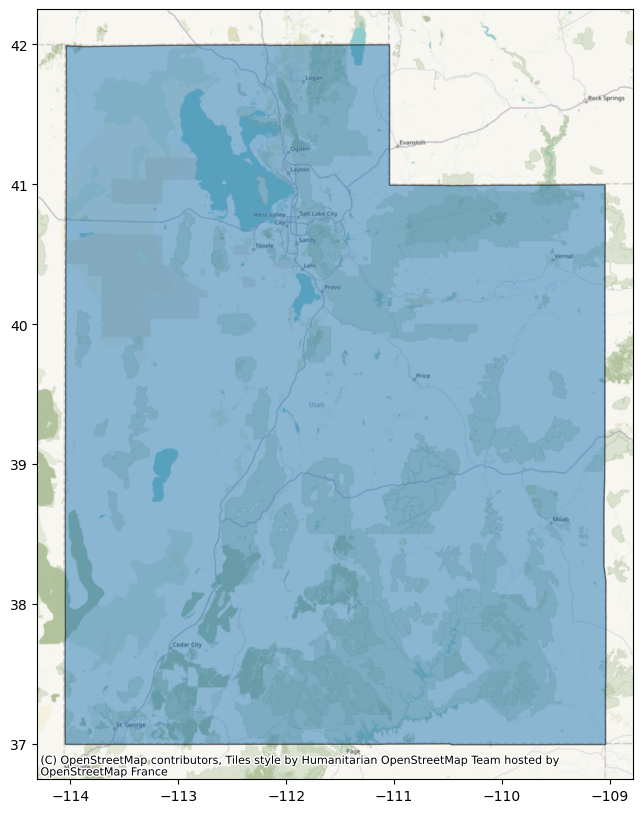

In [3]:
import contextily as cx

ax = utah.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs=utah.crs)

That looks right! 


## CRS

Let's check what the CRS is on this boundary file. This is important because we want the CRS to match our datacube CRS:

In [4]:
utah.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Conventionally, CRS information is stored on a variable named `spatial_ref` in the Xarray dataset. Let's check that.

In [5]:
ds["spatial_ref"].attrs

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'Geo

Both are `WGS 84`!


## A note on recording CRS information

The name `'spatial_ref'` is not necessarily special. It is a GDAL convention.

The Climate & Forecast (CF) conventions recommend storing the coordinate system information in a "grid mapping" variable:

> A grid mapping variable may be referenced by a data variable in order to explicitly declare the coordinate reference system (CRS) used for the horizontal spatial coordinate values.

To find the CRS for the `lclu` array specifically, 
1. look for `grid_mapping` attribute in `ds.lclu.attrs` (this is `spatial_ref`)
2. Now look at the attributes for that variable.

In [6]:
ds.lclu

<xarray.DataArray 'lclu' (year: 5, y: 560000, x: 1440000)> Size: 4TB
[4032000000000 values with dtype=uint8]
Coordinates:
  * y            (y) float64 4MB 80.0 80.0 80.0 80.0 ... -60.0 -60.0 -60.0 -60.0
  * year         (year) int64 40B 2000 2005 2010 2015 2020
    spatial_ref  int64 8B ...
  * x            (x) float64 12MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    publication:   Potapov, P., Hansen, M.C., Pickens, A., Hernandez-Serna, A...
    doi:           10.3389/frsen
    grid_mapping:  spatial_ref

These attributes are parsed by add-on tools like `rioxarray` and `odc-geo`

In [7]:
import rioxarray  # adds the `rio` accessor to Xarray

ds.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [8]:
import odc.geo.xr

ds.odc.crs

CRS('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

### Clipping

Now, let's clip our datacube to this boundary. We want to do this in such a way that we do not actually load in all of the data. In fact, rioxarray's [`clip_box`](https://corteva.github.io/rioxarray/stable/examples/clip_box.html) operation allows us to clip our datacube lazily!

In [9]:
bbox = utah.to_crs("EPSG:4326").total_bounds
clipped = ds.rio.clip_box(*bbox).chunk({"x": 1000, "y": 1000})
clipped

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 20016, year: 5, x: 20048)
Coordinates:
  * y            (y) float64 160kB 42.0 42.0 42.0 42.0 ... 37.0 37.0 37.0 37.0
  * year         (year) int64 40B 2000 2005 2010 2015 2020
  * x            (x) float64 160kB -114.1 -114.1 -114.1 ... -109.0 -109.0 -109.0
    spatial_ref  int64 8B 0
Data variables:
    lclu         (year, y, x) uint8 2GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
Attributes:
    license:  CC BY 4.0

We effectively just extracted all 5 years worth of LULC data for the state of Utah from the global datacube without loading the data in at all. Our datacube is now size `(year: 5, x: 20048, y: 20016)`. The total size of this datacube is 2GB. 

Notice how we chunked the data when we did the clip. The size of these chunks was determined based on the size of our clipped dataset. See the Appendix for a more detailed walkthrough on how to pick chunk sizes.

### Reprojecting

Our data is in EPSG:4326, but we may want the data in EPSG:3857 for web mapping or in the North American Datum 1983 (NAD83) coordinate reference system (EPSG:4269).

Reprojecting a datacube to a new CRS is quite simple; both rioxarray and ODC geo have helper functions to do just that. 

However, `.rio.reproject` will load data in to memory.
`odc-geo`'s `reproject` is dask-aware, and comes with many options. We will use `odc-geo` in this example.

In [11]:
clipped.odc.reproject?

Signature:
clipped.odc.reproject(
    how: 'Union[SomeCRS, GeoBox]',
    *,
    resampling: 'Union[str, int]' = 'nearest',
    dst_nodata: 'SomeNodata' = 'auto',
    dtype=None,
    resolution: "Union[SomeResolution, Literal['auto', 'fit', 'same']]" = 'auto',
    shape: 'Union[SomeShape, int, None]' = None,
    tight: 'bool' = False,
    anchor: 'GeoboxAnchor' = 'default',
    tol: 'float' = 0.01,
    round_resolution: 'Union[None, bool, Callable[[float, str], float]]' = None,
    **kw,
) -> 'XrT'
Docstring:
Reproject raster to different projection/resolution.

:param src:
  :py:class:`~xarray.Dataset` or :py:class:`~xarray.DataArray` to reproject.

:param how:
  How to reproject the raster. Can be a GeoBox or a CRS (e.g. CRS object or
  an "ESPG:XXXX" string/integer). If a CRS is provided, the output pixel
  grid can be customised further via ``resolution``, ``shape``, ``tight``,
  ``anchor``, ``tol``, ``round_resolution``.

:param resampling:
  Resampling method to use when reproject

In [10]:
clipped.odc.reproject("EPSG:4269")

<xarray.Dataset> Size: 2GB
Dimensions:      (year: 5, latitude: 20018, longitude: 20050)
Coordinates:
  * year         (year) int64 40B 2000 2005 2010 2015 2020
  * latitude     (latitude) float64 160kB 42.0 42.0 42.0 42.0 ... 37.0 37.0 37.0
  * longitude    (longitude) float64 160kB -114.1 -114.1 ... -109.0 -109.0
    spatial_ref  int32 4B 4269
Data variables:
    lclu         (year, latitude, longitude) uint8 2GB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>

### Masking

A common use-case for LULC data is to use it as a data mask on another dataset. Say you are only interested in regions that are forested; you could mask the LULC data into forest vs. not forested, and then apply that mask to another dataset of interest. Let's see what this could look like in practice.

According to the data legend, classes 25-48 represent some form of tree cover (on Terra Firma, there is a separate classification scheme for wetland tree cover). Creating a mask for this is quite trivial, we just have to construct a boolean operation for `25 <= lclu <= 48`. This operation is also done lazily:

In [12]:
tree_mask = (clipped["lclu"] >= 25) & (clipped["lclu"] <= 48)
tree_mask

<xarray.DataArray 'lclu' (year: 5, y: 20016, x: 20048)> Size: 2GB
dask.array<and_, shape=(5, 20016, 20048), dtype=bool, chunksize=(5, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 160kB 42.0 42.0 42.0 42.0 ... 37.0 37.0 37.0 37.0
  * year         (year) int64 40B 2000 2005 2010 2015 2020
  * x            (x) float64 160kB -114.1 -114.1 -114.1 ... -109.0 -109.0 -109.0
    spatial_ref  int64 8B 0

Alternatively if we were interested in "True desert" (0-1) and "Builtup" (250), we could use `.isin` to construct a mask

In [13]:
clipped.lclu.isin([0, 1, 250])

<xarray.DataArray 'lclu' (year: 5, y: 20016, x: 20048)> Size: 2GB
dask.array<any-aggregate, shape=(5, 20016, 20048), dtype=bool, chunksize=(5, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 160kB 42.0 42.0 42.0 42.0 ... 37.0 37.0 37.0 37.0
  * year         (year) int64 40B 2000 2005 2010 2015 2020
  * x            (x) float64 160kB -114.1 -114.1 -114.1 ... -109.0 -109.0 -109.0
    spatial_ref  int64 8B 0

In [ ]:
# This will perform the computation and load the data into memory
# Note: This is a large array, so it may take some time to compute
tree_mask = tree_mask.compute()
tree_mask

And there we have our mask! If you wanted to use this to mask another dataset (`data`), you can use xarray's [`where`]() method:
```python
masked_data = data.where(mask.astype(bool), other=255)  # Fill with no data value
```

Make sure mask and data have matching coordinates and dimensions (e.g., `time` or `year`, `x`, `y`, etc.). If not, you might need to [`align`]() them:
```python
data, mask = xr.align(data, mask)
```

### Calculating zonal stats

In theory, we could use this masking approach for zonal statistics. Say we wanted to calculate the proportion of tree cover over the state of Utah by year. We could sum the number of 1s (`True`) in our tree mask and divide that by the total number of pixels to get the proportion of tree cover:

In [14]:
# Count tree-covered pixels per year
tree_pixel_count_per_year = tree_mask.sum(dim=("y", "x"))

# Count total valid pixels per year
total_pixels = ds.sizes["x"] * ds.sizes["y"]

# Calculate percent tree cover per year
percent_tree_cover = (tree_pixel_count_per_year / total_pixels) * 100

# We already triggered compute above
# percent_tree_cover = percent_tree_cover.compute()
percent_tree_cover

<xarray.DataArray 'lclu' (year: 5)> Size: 40B
dask.array<mul, shape=(5,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * year         (year) int64 40B 2000 2005 2010 2015 2020
    spatial_ref  int64 8B 0

Let's plot this:

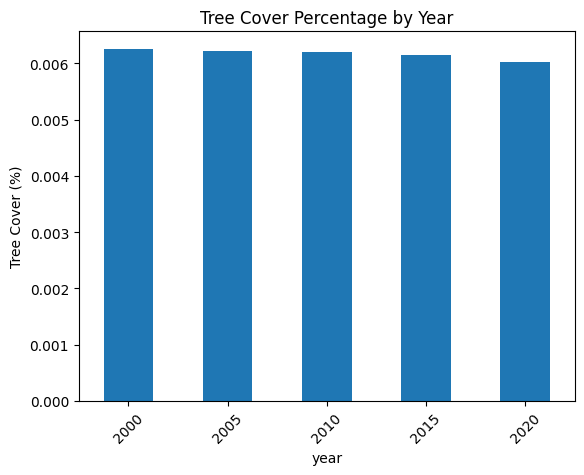

In [23]:
import matplotlib.pyplot as plt

percent_tree_cover.to_series().plot.bar()
plt.title("Tree Cover Percentage by Year")
plt.ylabel("Tree Cover (%)")
plt.xticks(rotation=45)
plt.show()

This approach is fine, but there is (in our opinion) a better way using xarray's [BinGrouper]().

In [16]:
import pandas as pd
from xarray.groupers import BinGrouper

legend = {
    "True desert": pd.Interval(0, 1, closed="both"),
    "Semi-arid": pd.Interval(2, 18, closed="both"),
    "Tree cover": pd.Interval(25, 48, closed="both"),
    "Open surface water": pd.Interval(200, 207, closed="both"),
    "Built-up": pd.Interval(250, 250, closed="both"),
}

index = pd.IntervalIndex(list(legend.values()))

land_grouper = BinGrouper(bins=index, labels=list(legend.keys()))

pixel_counts = clipped.groupby(lclu=land_grouper).count(dim=("y", "x"))  # .compute()
pixel_counts

<xarray.Dataset> Size: 288B
Dimensions:      (year: 5, lclu_bins: 5)
Coordinates:
  * year         (year) int64 40B 2000 2005 2010 2015 2020
    spatial_ref  int64 8B 0
  * lclu_bins    (lclu_bins) object 40B 'True desert' 'Semi-arid' ... 'Built-up'
Data variables:
    lclu         (year, lclu_bins) float64 200B dask.array<chunksize=(5, 5), meta=np.ndarray>
Attributes:
    license:  CC BY 4.0

Now lets accumulate by decade

In [20]:
decadal = pixel_counts.groupby(
    year=BinGrouper(bins=(2000, 2010, 2020), right=False)
).mean()
decadal

<xarray.Dataset> Size: 160B
Dimensions:      (year_bins: 2, lclu_bins: 5)
Coordinates:
    spatial_ref  int64 8B 0
  * lclu_bins    (lclu_bins) object 40B 'True desert' 'Semi-arid' ... 'Built-up'
  * year_bins    (year_bins) interval[int64, left] 32B [2000, 2010) [2010, 2020)
Data variables:
    lclu         (year_bins, lclu_bins) float64 80B dask.array<chunksize=(2, 5), meta=np.ndarray>
Attributes:
    license:  CC BY 4.0

In [21]:
# we might prefer calling this "decade"
decadal = decadal.rename({"year_bins": "decade"})
decadal

<xarray.Dataset> Size: 160B
Dimensions:      (decade: 2, lclu_bins: 5)
Coordinates:
    spatial_ref  int64 8B 0
  * lclu_bins    (lclu_bins) object 40B 'True desert' 'Semi-arid' ... 'Built-up'
  * decade       (decade) interval[int64, left] 32B [2000, 2010) [2010, 2020)
Data variables:
    lclu         (decade, lclu_bins) float64 80B dask.array<chunksize=(2, 5), meta=np.ndarray>
Attributes:
    license:  CC BY 4.0

### Choose your own adventure!

Now is the portion of this workshop where you are free to answer your own research question that intrigues you with this global GLAD datacube. Here is a list of queries to get you started, but feel free to explore what interests you the most!

- What is the change in percent tree cover over Brazil by year? 
- What is the change in urbanization in a specific AOI since 2000? 
    - 🌍 Cities with Significant Urbanization (1995–2025)
      - Chongqing, China
      - Dhaka, Bangladesh
      - Kinshasa, Democratic Republic of Congo
      - Jakarta, Indonesia
      - Lahore, Pakistan
- See if you can corroborate one of the below trends in agriculture land use:
  - **Increased Cropland:** Sub-Saharan Africa, Southeast Asia, and parts of Latin America (e.g., Brazil) have seen significant expansion of cropland since 2000.
  - **Decreased Cropland:** Some regions in Europe, the U.S., and Japan have experienced reductions in cropland due to urbanization, economic shifts, or agricultural abandonment.
  - **Mixed Trends:** Countries like China and India have mixed trends, where some areas are expanding cropland while others are losing it to urban development or other uses.

If you get stuck, do not hesitate to ask questions, and feel free to collaborate with your fellow workshop participants. This is your time to get what YOU want out of this workshop 😊 

In [13]:
# Insert your code here

## Wrapping it up with Icechunk

TODO: show how icechunk is useful in the global datacube example

# The Grand Finale